# Tutorial 2: Filtering and Pre-Processing

This notebook shows how to pre-process and filter trajectory dataframes using `nomad`. The `nomad` library currently provides functions for coordinate-system projection, and spatial, temporal, and quantity filtering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from datetime import datetime
import matplotlib.patches as patches
from pyproj import Transformer

import nomad.io.base as loader
import nomad.filters as filters
from nomad.filters import to_projection, filter_users
import nomad.city_gen as cg

### Load Data

For the following examples, we load test data from `nomad`.

In [2]:
raw_traj = loader.from_file('../nomad/data/gc_sample.csv', format='csv')
raw_traj.head(10)

,uid,timestamp,tz_offset,longitude,latitude
0,wizardly_joliot,1704120060,-18000,38.321669,-36.667588
1,wizardly_joliot,1704122760,-18000,38.321849,-36.667467
2,wizardly_joliot,1704124380,-18000,38.321752,-36.667464
3,wizardly_joliot,1704137280,-18000,38.321629,-36.667374
4,wizardly_joliot,1704138780,-18000,38.321636,-36.667238
5,wizardly_joliot,1704139740,-18000,38.321654,-36.667281
6,wizardly_joliot,1704140340,-18000,38.321641,-36.667338
7,wizardly_joliot,1704143280,-18000,38.321589,-36.667410
8,wizardly_joliot,1704143400,-18000,38.321687,-36.667524
9,wizardly_joliot,1704143580,-18000,38.321703,-36.667460


### Project between coordinate systems

Many geospatial datasets come in spherical coordiantes latitude/longitude (EPSG:4326). However, spatial analyses---like joins of points in polygons, computing buffers, or clustering pings---might benefit from computing euclidean distances. Thus projected planar coordinates (like EPSG:3857) are commonly used. Nomad's `to_projection` method creates new columns `x` and `y` with projected coordinates in any coordinate reference system (CRS) recognized by PyProj. 


In [3]:
# Project to EPSG:3857 (Web Mercator)
projected_x, projected_y = to_projection(traj=raw_traj,
                                         input_crs="EPSG:4326",
                                         output_crs="EPSG:3857",
                                         longitude="longitude",
                                         latitude="latitude")

traj = raw_traj.copy()
traj['x'] = projected_x
traj['y'] = projected_y

The following code visualizes the trajectory. We transform the coordinates in the sample data back to the Garden City coordinates (in a 22x22 box) so that we can visualize the city buildings alongside the blocks. The red box depicts the area we will filter to.

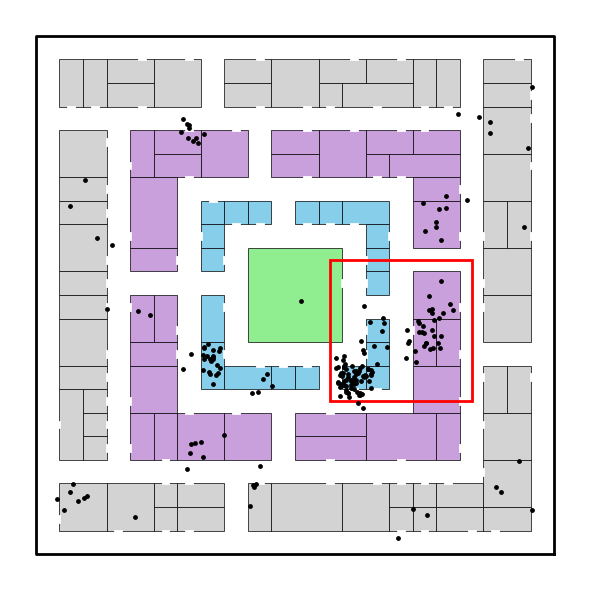

In [4]:
plot_df = traj[traj['uid'] == "agitated_chebyshev"].copy()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_df['x'], plot_df['y'] = transformer.transform(plot_df['longitude'].values, plot_df['latitude'].values)
plot_df['x'] = (plot_df['x'] - 4265699)/15
plot_df['y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=False)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

polygon_coords = [
    (12.5, 12.5), 
    (12.5, 6.5), 
    (18.5, 6.5), 
    (18.5, 12.5)
]
polygon = Polygon(polygon_coords)

polygon_patch = patches.Polygon(polygon.exterior.coords, closed=True, edgecolor='red', facecolor='none', linewidth=2, label="Polygon")
plt.gca().add_patch(polygon_patch)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Filter to a specified geometry

We often need to filter down the dataset to the most relevant records. This involves filtering along three key dimensions:
- Spatial Filtering: Keep only users with pings that fall within a specific geographic region (e.g., Philadelphia). Use the `polygon` argument.
- Temporal Filtering: Restrict data to a time window of interest (e.g., January). Use the `start_time` and `end_time` arguments. If 
- Quantity-Based Filtering: Keep only users with sufficient activity as measured by a minimum number of pings. Use the `min_active_days` and `min_pings_per_day` arguments.

If the aforementioned arguments are not specified, the default arguments ensure that the respective filtering is not performed. E.g., `polygon` defaults to `None`, and so no spatial filtering is performed.

These filtering functions help clean and prepare your dataset for downstream analysis by focusing only on users who are present, active, and engaged in the geographic area and timeframe you care about.

In [5]:
polygon_coords = [
    (4265886.5, -4392788.5), 
    (4265886.5, -4392878.5), 
    (4265976.5, -4392878.5), 
    (4265976.5, -4392788.5)
]
polygon = Polygon(polygon_coords)

n0 = len(traj)
uq0 = traj['uid'].unique()

filtered_traj = filter_users(traj=traj, 
                             start_time="2024-01-01 00:00:00",
                             end_time="2024-01-31 23:59:00",
                             polygon=polygon,
                             min_active_days=2,
                             min_pings_per_day=10,
                             user_id='uid',
                             x='x',
                             y='y')

n1 = len(filtered_traj)
uq1 = filtered_traj['uid'].unique()
print(f"Number of pings before filtering: {n0}")
print(f"Number of unique users before filtering: {len(uq0)}")
print(f"Number of pings after filtering: {n1}")
print(f"Number of unique users after filtering: {len(uq1)}")


Number of pings before filtering: 26977
Number of unique users before filtering: 100
Number of pings after filtering: 15912
Number of unique users after filtering: 35
